In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('understat_per_game.csv')

In [4]:
# Handle outliers in the target variable ('scored') using the IQR method
Q1 = data['scored'].quantile(0.25)  # First quartile (25th percentile)
Q3 = data['scored'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[(data['scored'] >= lower_bound) & (data['scored'] <= upper_bound)]

print(f"Dataset shape after removing outliers: {data.shape}")

Dataset shape after removing outliers: (24420, 29)


In [5]:
# Step 3: Drop goal-related features and non-useful columns
high_corr_features = ['pts', 'npxG', 'npxGD', 'xG', 'xG_diff', 'wins', 'npxG', 
                      'xpts', 'xGA_diff', 'xGA', 'npxGA', 'xpts_diff', 'loses', 'draws']
data = data.drop(columns=high_corr_features + ['result', 'date', 'team', "year"])

In [6]:
# Step 4: Feature Engineering
data['ppda_efficiency'] = data['ppda_att'] / (data['ppda_def'] + 1)
data['oppda_efficiency'] = data['oppda_att'] / (data['oppda_def'] + 1)
data['relative_ppda_efficiency'] = data['ppda_efficiency'] / (data['oppda_efficiency'] + 1)
data['ppda_intensity'] = data['ppda_coef'] * data['ppda_att']
data['oppda_intensity'] = data['oppda_coef'] * data['oppda_att']
data['intensity_diff'] = data['ppda_intensity'] - data['oppda_intensity']

# Add interaction features
data['deep_x_ppda_intensity'] = data['deep'] * data['ppda_intensity']
data['deep_x_oppda_intensity'] = data['deep'] * data['oppda_intensity']
data['deep_x_intensity_diff'] = data['deep'] * data['intensity_diff']

# Add polynomial features for 'deep' and 'intensity_diff'
data['deep_squared'] = data['deep'] ** 2
data['deep_cubed'] = data['deep'] ** 3
data['intensity_diff_squared'] = data['intensity_diff'] ** 2
data['intensity_diff_cubed'] = data['intensity_diff'] ** 3


In [7]:
# Step 5: Apply one-hot encoding to categorical columns ('h_a')
data = pd.get_dummies(data, columns=['h_a', 'league'], drop_first=True)

In [8]:
# Step 6: Define target and features for predicting 'scored'
X = data.drop(columns=['scored'])  # Features
y = data['scored']  # Target variable (actual goals scored)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Step 8: Initialize the Random Forest Regressor with optimal hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42
)

# Step 9: Cross-validation
cv_mae_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_scores = -cv_mae_scores  # Convert negative MAE to positive for interpretability

cv_mae_mean = np.mean(cv_mae_scores)
cv_mae_std = np.std(cv_mae_scores)

print("\nCross-Validation Results (MAE):")
print(f"Cross-Validation Mean MAE: {cv_mae_mean}")
print(f"Cross-Validation Standard Deviation of MAE: {cv_mae_std}")
print(f"MAE Scores for Each Fold: {cv_mae_scores}")


Cross-Validation Results (MAE):
Cross-Validation Mean MAE: 0.8767528838500229
Cross-Validation Standard Deviation of MAE: 0.010043280120574708
MAE Scores for Each Fold: [0.87503148 0.89431428 0.87225012 0.86372118 0.87844736]


In [10]:
# Step 10: Train the model on the full training set
rf_model.fit(X_train, y_train)

# Step 11: Make predictions and evaluate the model on the test set
y_pred_rf_test = rf_model.predict(X_test)
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print("\nRandom Forest Model Test Set Performance (Predicting Scored):")
print(f"Mean Absolute Error (MAE): {mae_rf_test}")
print(f"Mean Squared Error (MSE): {mse_rf_test}")
print(f"R-squared (R2): {r2_rf_test}")


Random Forest Model Test Set Performance (Predicting Scored):
Mean Absolute Error (MAE): 0.8771788520144101
Mean Squared Error (MSE): 1.2065370831850721
R-squared (R2): 0.1286536016700418


In [11]:
# Step 12: Evaluate the model on the training set to check for overfitting
y_train_pred = rf_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Performance (Predicting Scored):")
print(f"Training Set Mean Absolute Error (MAE): {train_mae}")
print(f"Training Set R-squared (R2): {train_r2}")


Training Set Performance (Predicting Scored):
Training Set Mean Absolute Error (MAE): 0.8067129698024332
Training Set R-squared (R2): 0.2583250346614241



Feature Importances based on Random Forest Model:
                     Feature  Importance
16    deep_x_oppda_intensity    0.082234
7                  oppda_att    0.076623
18              deep_squared    0.073735
0                       deep    0.069129
19                deep_cubed    0.068324
15     deep_x_ppda_intensity    0.065372
17     deep_x_intensity_diff    0.053684
4                   ppda_att    0.045498
12            ppda_intensity    0.043081
13           oppda_intensity    0.042193
21      intensity_diff_cubed    0.035373
14            intensity_diff    0.032535
11  relative_ppda_efficiency    0.030859
3                  ppda_coef    0.030772
9            ppda_efficiency    0.030451
10          oppda_efficiency    0.029601
6                 oppda_coef    0.029279
20    intensity_diff_squared    0.027585
22                     h_a_h    0.027266
8                  oppda_def    0.025632
2                     missed    0.023240
5                   ppda_def    0.023222
1     

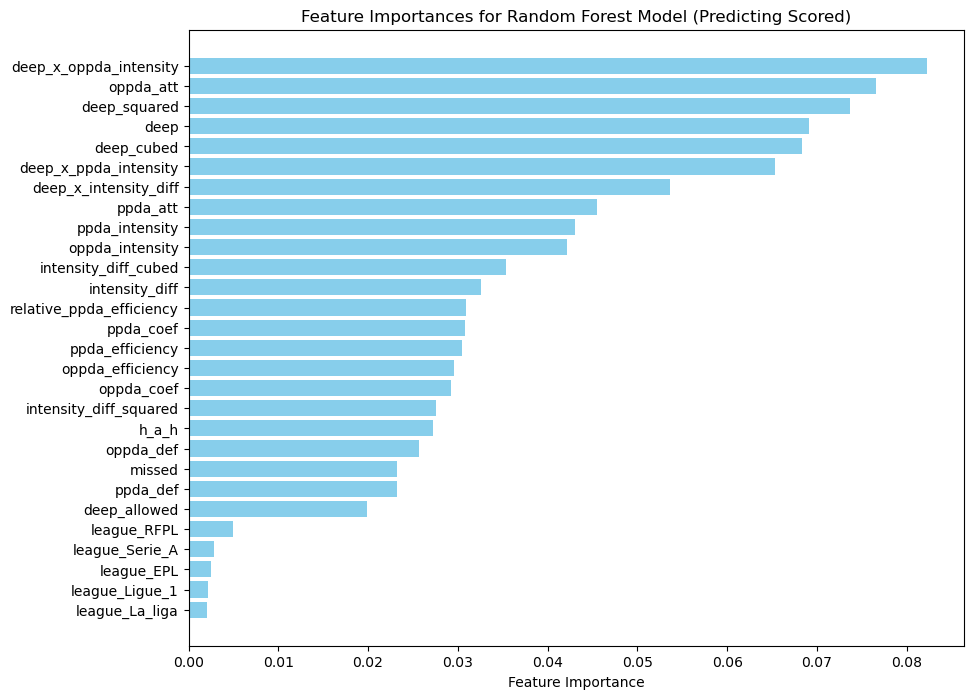

In [12]:
# Step 13: Display feature importances for Random Forest
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances based on Random Forest Model:")
print(feature_importances)

# Step 14: Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances for Random Forest Model (Predicting Scored)')
plt.gca().invert_yaxis()
plt.show()